In [153]:
from sktime.registry import all_estimators
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_percentage_error, mean_squared_error
from sktime.utils.plotting import plot_series

from matplotlib import pyplot as plt
import seaborn as sns

## Time Series Forecasting with SKtime

SKtime provides a familiar interface to time series functionality. 

### Common Lingo

<ul>
<li> forecaster = model
<li> ForecasterHorizon = what to create predictions for
</ul>

#### Load Airline Data

(<Figure size 1440x360 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

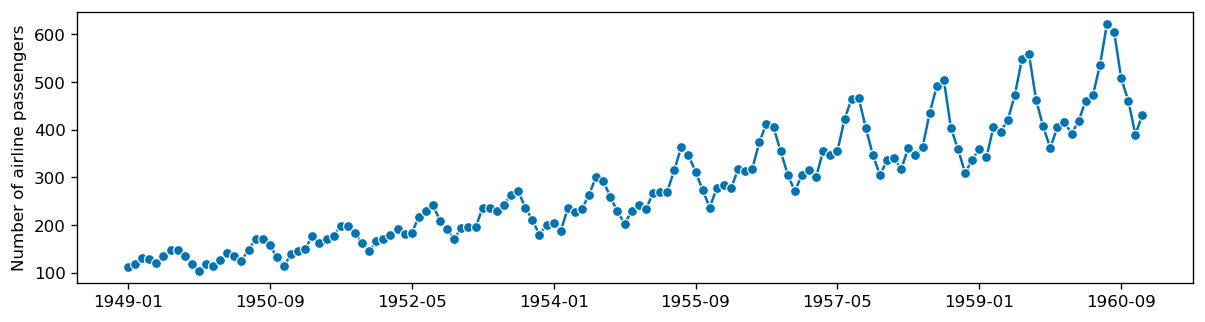

In [192]:
y = load_airline()
plot_series(y)

## Train-Test Split

Since time series runs sequentially, the train-test split for error calcualtions is normally just chopping off the last part of the sequence and use that to test. Sktime provides a dedicated function to do so. You'll commonly see array notation to slice before/after as well. 

Here we take the final 36 months for testing. We also make a forecast horizion, this one is set to be the months of the test data, since we are evaluating accuracy. 

In [156]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
fh = ForecastingHorizon(y_test.index, is_relative=False)

## Exponential Smoothing. 

We can guess that the period is 12 months since it looks like a yearly pattern. We can also try the trend being additive and the seasonality being multiplicitive. 

### Additive or Multiplicitive

Rule of thumb: if the difference is changing over time -> multiplicitive, if it is constant -> additive. 

Here the size of the seasonal swings seems to be getting larger, so that is multiplicitive. The trend seems to be a constant increase, so additive. We can see how to test these later - it is not always obvious. 

In [157]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

0.0033508158084145203

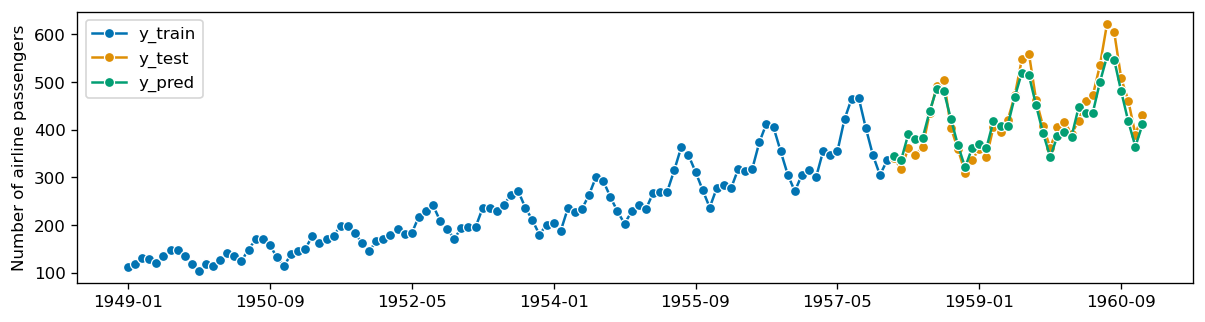

In [226]:
forecaster = ExponentialSmoothing(trend="add", seasonal="mul", sp=12)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_squared_percentage_error(y_pred, y_test)

Results - it looks like our model was pretty good. What if we want to make predictions into the future? We need to modify the forecasting horizion to, well, look into the horizon, then it is pretty similar. We can give the month indicies for the future months, as well as an argument "is_relative" that will tell sktiem to pick up at the end. 

We can also retrain the model to use all the data, since we are done evaluating the model here. 

(<Figure size 1440x360 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

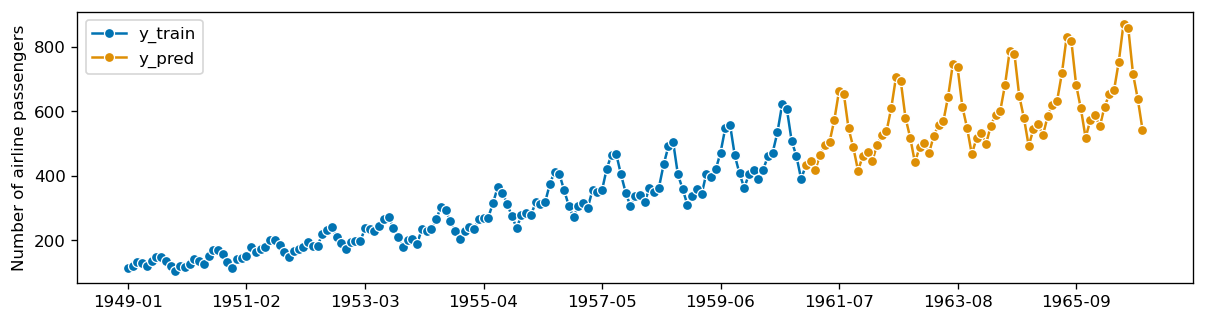

In [227]:
# Next 6 years
dates_range = list(range(0, 72))
fh_long = ForecastingHorizon(values=dates_range, is_relative=True)
forecaster.fit(y)
y_pred = forecaster.predict(fh_long)
plot_series(y, y_pred, labels=["y_train", "y_pred"])

## ARIMA

We can try a similar approach with an ARIMA model. 

In [160]:
from sktime.forecasting.arima import ARIMA

#### AD Fuller Test for D Term

The number of .diff()s in the code is the number of differences that we are introducing. Having one yeilded a value very close to .05, so we can try that for D. 

ADF Statistic: -2.829267
p-value: 0.054213


(<Figure size 1440x360 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

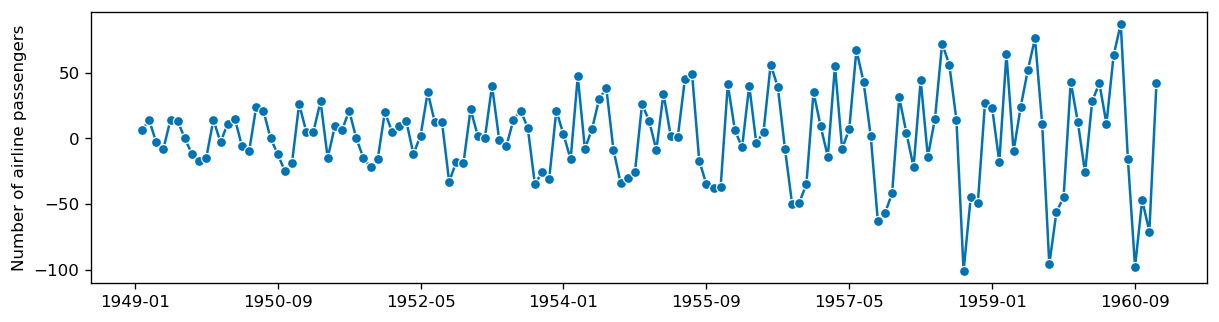

In [216]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
plot_series(y.diff())

## Partial Autocorrelation and Partial Autocorrelation for MA and AR. 

Determining p and q is a little more haphazard. Below is a processes to look for them with the ACF and PACF charts. In short, we can look for a starting point, then potentially adjust. We will have a solution for this soon...

<b>Process:</b>
<ol>
<li>If the PACF of the differenced series shows a sharp cut off and/or the lag1 autocorrelation is positive (this indicates an ‘under- differenced’ series) while the ACF decays more slowly , then consider adding an AR term to the model. The number of AR terms will depend on the lag at which PACF cuts off.
<li>If the ACF of the differenced series shows a sharp cut off and/or the lag1 autocorrelation is negative (this indicates an ‘over- differenced’ series) while the PACF decays more slowly , then consider adding MA term to the model. Here, the autocorrelation pattern is explained more by adding the MA terms. The number of MA terms will depend on the lag at which ACF cuts off.
<li>An AR term is associated with under-differencing or positive auto correlation at lag 1while an MA term is associated with over-differencing or negative auto correlation at lag 1.
</ol>

In [162]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

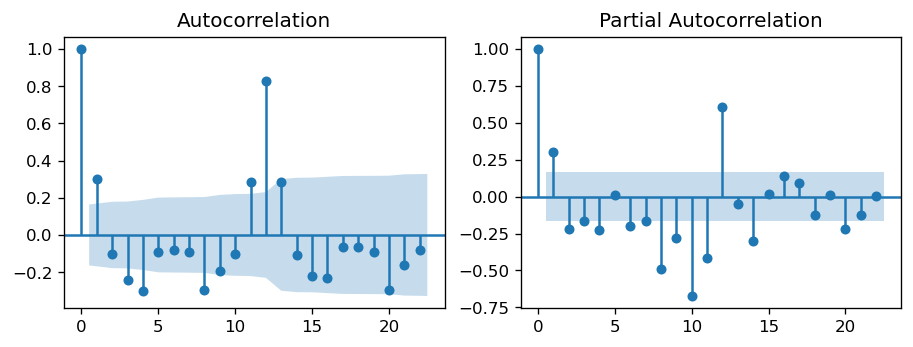

In [220]:
# ACF/PACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2)
plot_acf(y.diff().dropna(), ax=axes[0])
plot_pacf(y.diff().dropna(), ax=axes[1])

plt.show()

We can try:
<ul>
<li> AR (p) - 1
<li> I (d) - 1
<li> MA (q) - 1
</ul>

### Seasonality

Seasonality - we can guess pretty easily that it is a one year pattern, so we can include that as m. The seasonal_order attributes are:

<ul>
<li> P: Seasonal autoregressive order
<li> D: Seasonal difference order
<li> Q: Seasonal moving average order
<li> m: The number of time steps for a single seasonal period
</ul>

### Check D

AD Fuller test. p Value is small, no differencing needed. 

In [234]:
result = adfuller((y-y.shift(12)).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.383021
p-value: 0.011551


#### Check P and Q

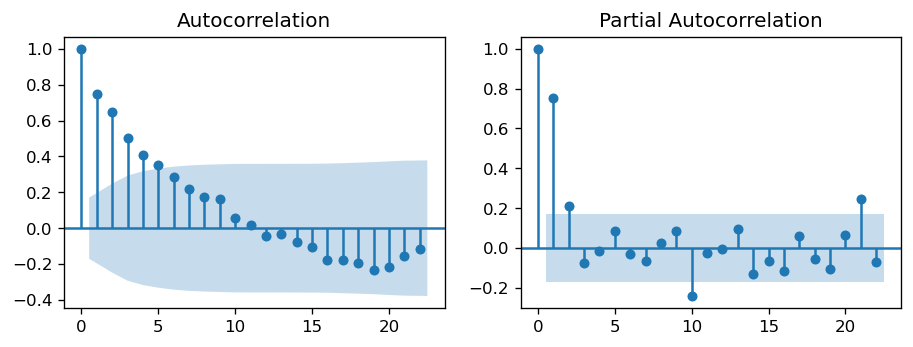

In [235]:
fig, axes = plt.subplots(1, 2)
plot_acf((y-y.shift(12)).dropna(), ax=axes[0])
plot_pacf((y-y.shift(12)).dropna(), ax=axes[1])
plt.show()

0.0033417465210943474

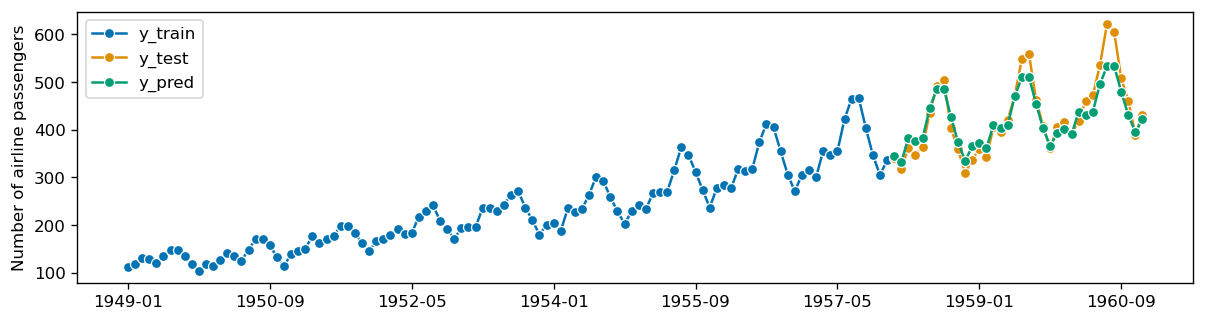

In [238]:
forecaster = ARIMA(order=(1, 1, 1), seasonal_order=(2, 0, 0, 12), suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_squared_percentage_error(y_pred, y_test)

#### Predict Into Future

(<Figure size 1440x360 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

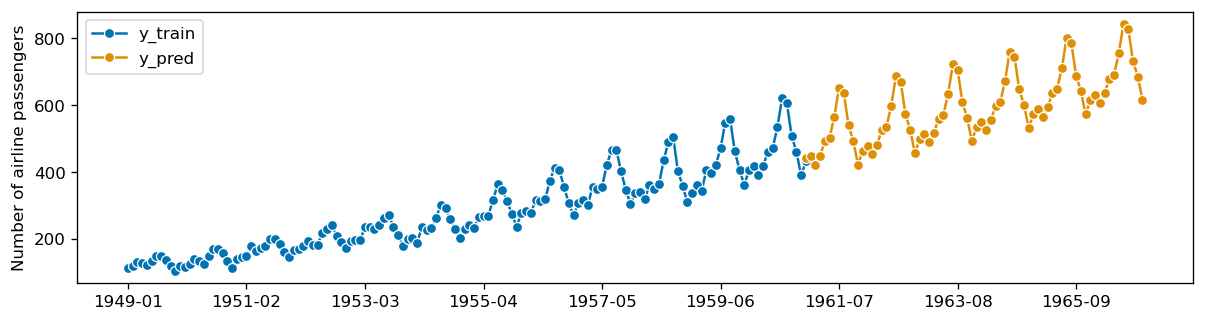

In [222]:
dates_range = list(range(0, 72))
fh_long = ForecastingHorizon(values=dates_range, is_relative=True)
forecaster.fit(y)
y_pred = forecaster.predict(fh_long)
plot_series(y, y_pred, labels=["y_train", "y_pred"])

## AutoARIMA

Going through all that work to find ARIMA terms seems suboptimal, and it is. We can use AutoARIMA to do a grid-search-ish process to find the ARIMA values for us. 

We supply the sp=12 for the seasonality pattern. Try without it, or with something different and observe. 

In [166]:
from sktime.forecasting.arima import AutoARIMA

0.04117062370076287
{'ar.L1': -0.24111779069756423, 'sigma2': 92.7498597090185, 'order': (1, 1, 0), 'seasonal_order': (0, 1, 0, 12), 'aic': 704.001167902485, 'aicc': 704.1316026850938, 'bic': 709.1089216856861, 'hqic': 706.0650836394865}


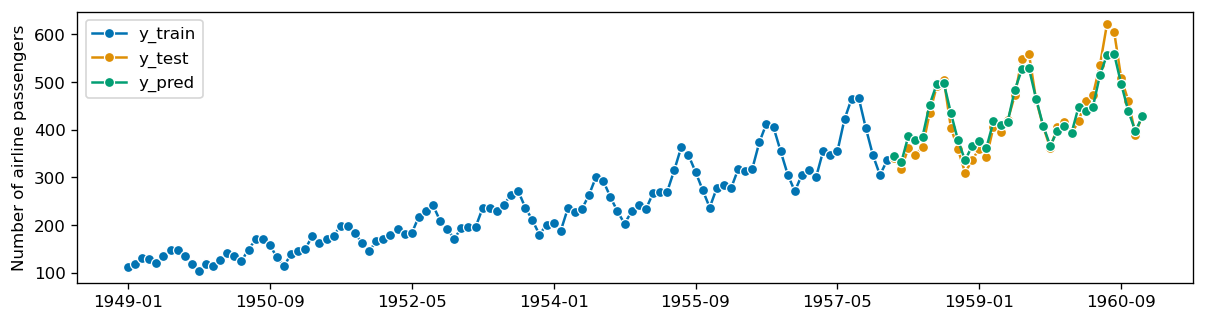

In [240]:
forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(mean_absolute_percentage_error(y_pred, y_test))
print(forecaster.get_fitted_params())

## Automated Tools and Pipelines

Since sktime is structured like sklearn, we can incorporate things into standard functionality like pipelines. The sktime library provides a TransformedTargetForecaster that we can use as a pipeline - the reason for this difference is because the time series data is the target data, not the feature set like a normal pipeline. 

There are also a few other automated tools that we won't explore in detail, but are clearly named and explained in the documentation:
<ul>
<li> Detrender - remove trends from time series. 
<li> Deseasonalizer - remove seasonality from time series. 
</ul>

Both transform the time series data to remove the non-stationary bits. 

In [168]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer

0.05878219160849463

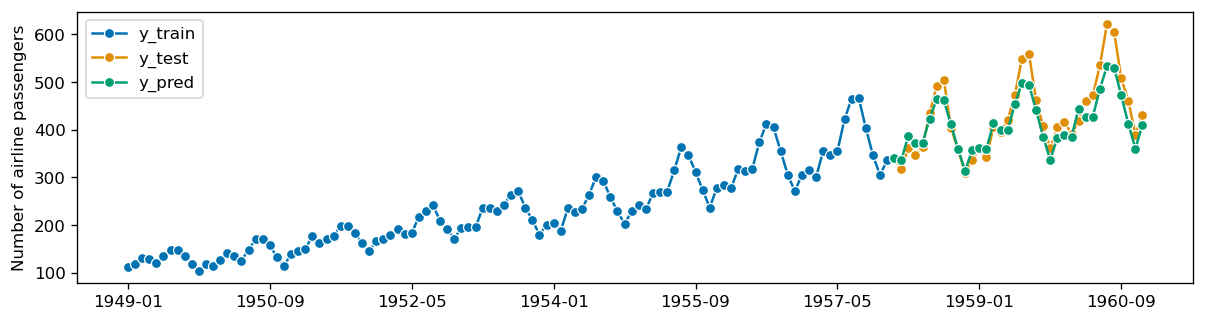

In [224]:
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("forecast", AutoARIMA()),
    ])

forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

### GridSearch

We can also use a forecasting grid search to test for the best parameters, just like normal. The customizations here are:
<ul>
<li> The crossvalidation is provided by the SlidingWindowSplitter, which will slice a time series into windows for tests. 
<li> The OptionalPassthrough allows the True/False inclusion in the cv, so we can test if things should be included or not. 
</ul>

In [193]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter
from sktime.transformations.series.compose import OptionalPassthrough
from sktime.transformations.series.detrend import Deseasonalizer

In [194]:
# create pipeline
pipe = TransformedTargetForecaster(
    steps=[
        ("deseasonalizer", OptionalPassthrough(Deseasonalizer())),
        ("forecaster", ExponentialSmoothing()),
    ])

# putting it all together in a grid search
cv = SlidingWindowSplitter(initial_window=36, window_length=24, start_with_window=True, step_length=24)

param_grid = {
    "deseasonalizer__passthrough": [True, False],
    "forecaster__sp": [2,3,4,5,6,7,8,9,10,11,12],
    "forecaster__trend": ["add", "mul"],
    "forecaster__seasonal": ["add", "mul"]
}
gscv = ForecastingGridSearchCV(forecaster=pipe, param_grid=param_grid, cv=cv, n_jobs=-1)

0.0033508158084145203
{'deseasonalizer__passthrough': True, 'forecaster__seasonal': 'mul', 'forecaster__sp': 12, 'forecaster__trend': 'add'}


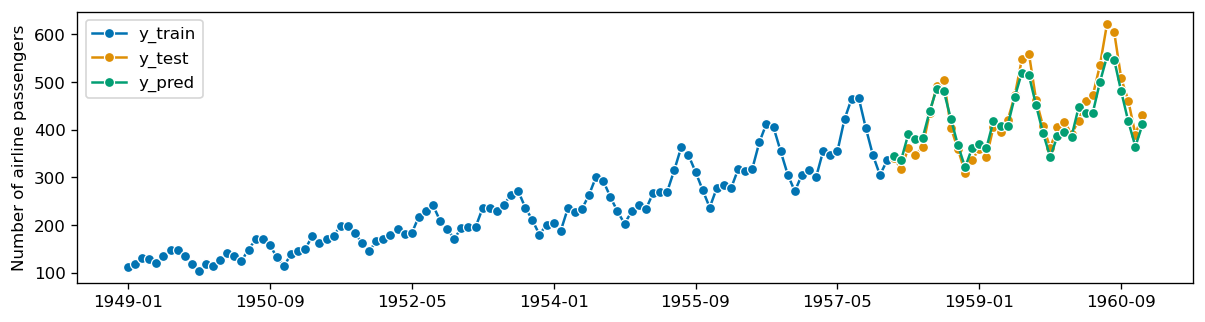

In [197]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(mean_squared_percentage_error(y_pred, y_test))
print(gscv.best_params_)

## FaceBook Prophet

One different thing that we can do with sktime is that we can import a pre-trained model and use it - in this case something offered by Facebook called Prophet. 

This package is a more sophisticated model for time series predictions created by Facebook. We can look to the documentation for details.

In [ ]:
from sktime.forecasting.fbprophet import Prophet

0.06836731912311093

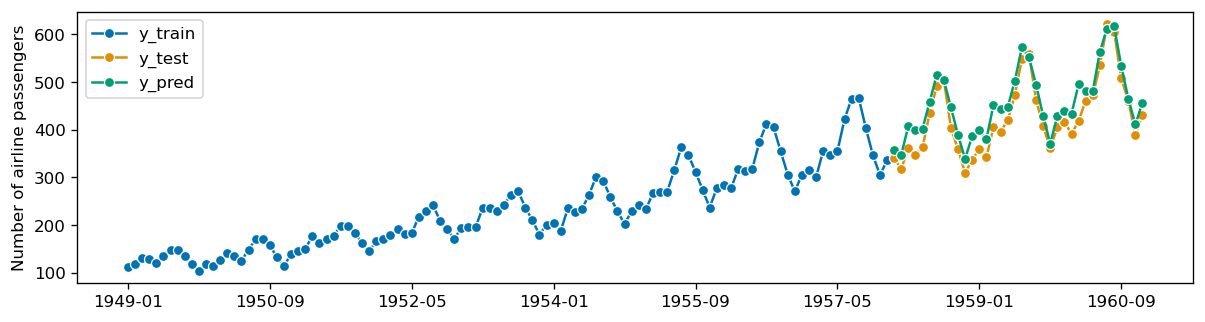

In [ ]:
# Convert index to pd.DatetimeIndex
z = y.copy()
z = z.to_timestamp(freq="M")
z_train, z_test = temporal_train_test_split(z, test_size=36)


forecaster = Prophet(
    seasonality_mode="multiplicative",
    n_changepoints=int(len(y_train) / 12),
    add_country_holidays={"country_name": "Canada"},
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
)

forecaster.fit(z_train)
y_pred = forecaster.predict(fh.to_relative(cutoff=y_train.index[-1]))
y_pred.index = y_test.index

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
mean_absolute_percentage_error(y_pred, y_test)

## Working Example

36


(<Figure size 1440x360 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

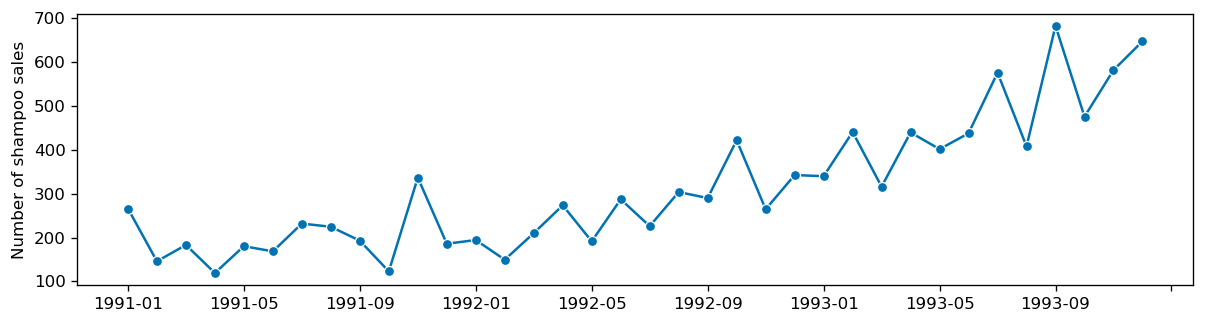

In [ ]:
from sktime.datasets import load_shampoo_sales
sh = load_shampoo_sales()
print(len(sh))
plot_series(sh)

#### Split

In [ ]:
sh_train, sh_test = temporal_train_test_split(sh, test_size=12)
sh_fh = ForecastingHorizon(sh_test.index, is_relative=False)

#### Exponential Smoothing

0.09603849373916301

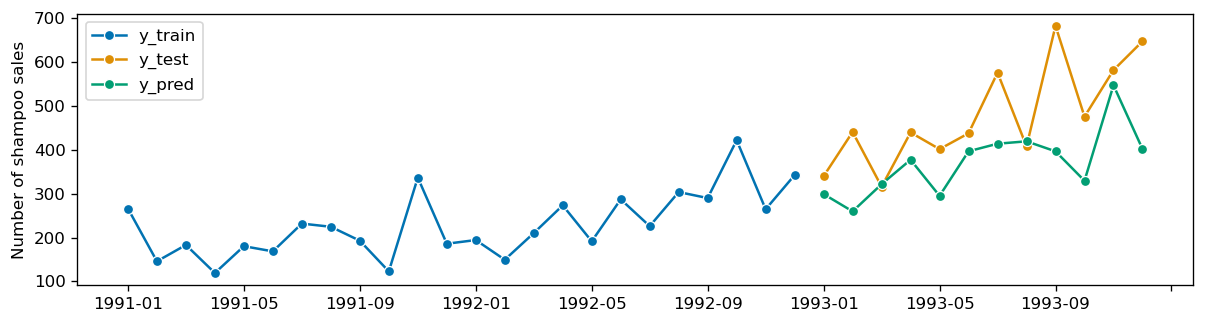

In [ ]:
sh_fore = ExponentialSmoothing(trend="mul", seasonal="add", sp=12)

sh_fore.fit(sh_train)
sh_pred = sh_fore.predict(sh_fh)
plot_series(sh_train, sh_test, sh_pred, labels=["y_train", "y_test", "y_pred"])
mean_squared_percentage_error(sh_pred, sh_test)

#### ARIMA

In [203]:
sh_result = adfuller(sh.diff().dropna())
print('ADF Statistic: %f' % sh_result[0])
print('p-value: %f' % sh_result[1])

ADF Statistic: -3.715053
p-value: 0.003906


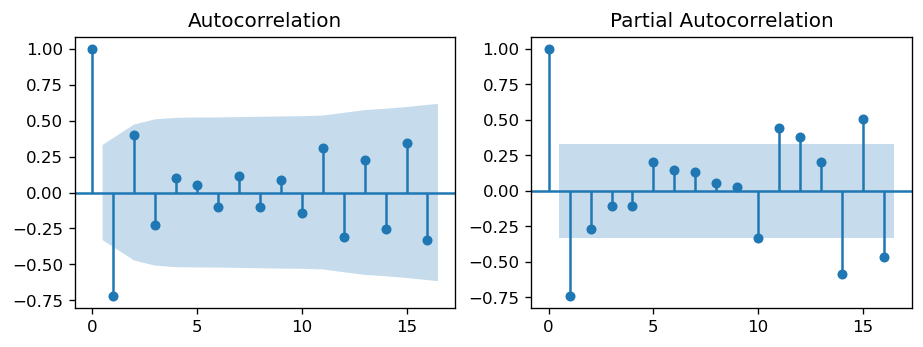

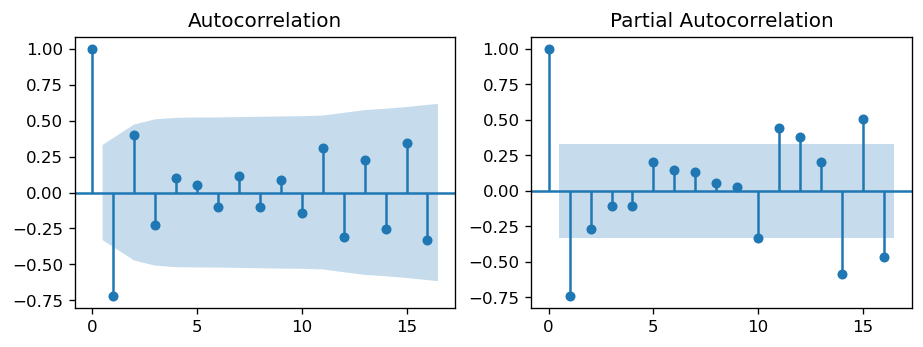

In [204]:
# PACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2)
plot_acf(sh.diff().dropna(), ax=axes[0])
plot_pacf(sh.diff().dropna(), ax=axes[1])


0.04230164883094533

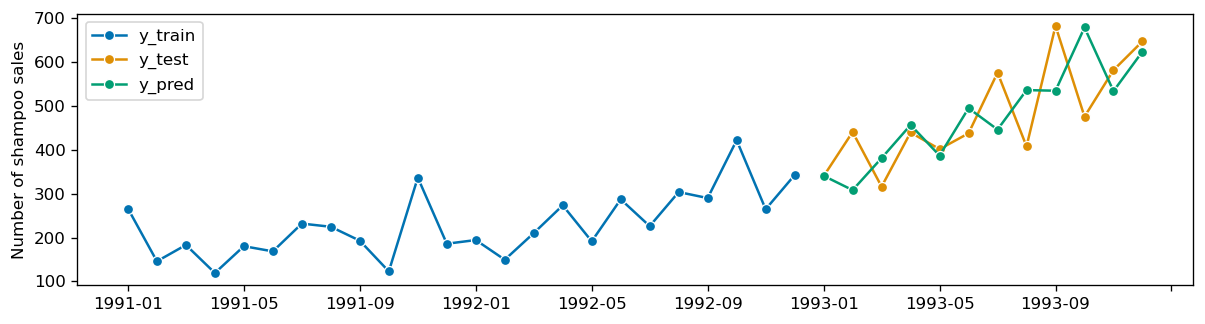

In [219]:
sh_fore = ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 0, 12), suppress_warnings=True)

sh_fore.fit(sh_train)
sh_pred = sh_fore.predict(sh_fh)
plot_series(sh_train, sh_test, sh_pred, labels=["y_train", "y_test", "y_pred"])
mean_squared_percentage_error(sh_pred, sh_test)

#### AutoARIMA

0.06117598652468895
{'intercept': 19.271932337817855, 'ar.L1': -0.35416235764651693, 'ma.L1': -0.772227374482889, 'ar.S.L12': -0.6493358188861966, 'sigma2': 2192.8298380161045, 'order': (1, 1, 1), 'seasonal_order': (1, 0, 0, 12), 'aic': 260.29474441087916, 'aicc': 263.824156175585, 'bic': 265.9722154905249, 'hqic': 261.72261247382687}


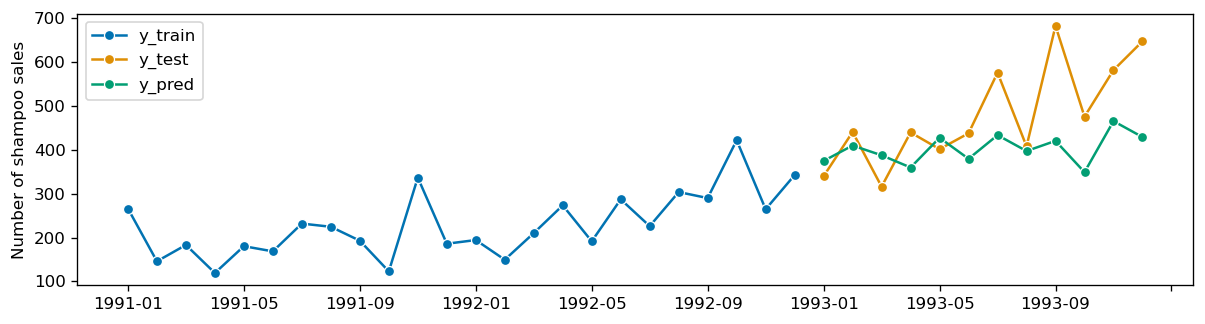

In [213]:
sh_fore = AutoARIMA(sp=12, suppress_warnings=True)

sh_fore.fit(sh_train)
sh_pred = sh_fore.predict(sh_fh)
plot_series(sh_train, sh_test, sh_pred, labels=["y_train", "y_test", "y_pred"])
print(mean_squared_percentage_error(sh_pred, sh_test))
print(sh_fore.get_fitted_params())

#### Predict Into Future

(<Figure size 1440x360 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

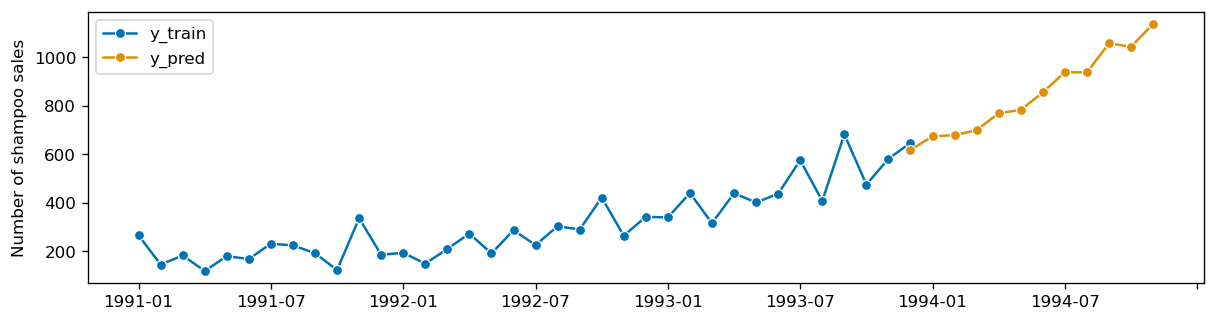

In [ ]:
sh_fore = ExponentialSmoothing(trend="mul", seasonal="add", sp=12)

sh_range = list(range(0, 12))
sh_long = ForecastingHorizon(values=sh_range, is_relative=True)
sh_fore.fit(sh)
sh_pred = sh_fore.predict(sh_long)
plot_series(sh, sh_pred, labels=["y_train", "y_pred"])